In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import linalg
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
outpath = "output/spliz_PCA/"

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [26]:
# dataname = "TSP1_10x_with_postprocessing_nopanc_cellann"
dataname = "TSP2_10x_rerun_with_postprocessing_3prime_cellann"
# dataname = "Tabula_muris_senis_P1_10x_with_postprocessing_cellann"
# dataname = "Lemur_10x_Antoine_with_postprocessing_cellann"
z_col = "scZ"
df = pd.read_parquet("../data/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(dataname),columns=["cell","geneR1A_uniq",z_col,"cell_gene","compartment","tissue","numReads"])

# make compartment labels the same for lemur
df["compartment"] = df["compartment"].replace("lymphoid","Immune")
df["compartment"] = df["compartment"].replace("myeloid","Immune")
df["compartment"] = df["compartment"].replace("megakaryocyte-erythroid","Immune")
df["compartment"] = df["compartment"].replace("stromal","Stromal")
df["compartment"] = df["compartment"].replace("epithelial","Epithelial")
df["compartment"] = df["compartment"].replace("endothelial","Endothelial")
df["compartment"] = df["compartment"].replace("immune","Immune")

In [27]:
df["num_splicedreads"] = df.groupby("cell_gene")["numReads"].transform("sum")
zdict = {"scZ" : 0.5}
comp_genes =["ATP5F1C","RPS24"]
df = df.drop_duplicates("cell_gene")
df = df[df["geneR1A_uniq"].isin(comp_genes)]
df["num_genes"] = df["cell"].map(df.groupby("cell")["geneR1A_uniq"].nunique())
# df = df[df["num_genes"] > 10]
df = df[df["num_genes"] > 1]
df["cell"].nunique()

10087

In [28]:
df["compartment"].value_counts()

Epithelial     8442
Immune         8408
Stromal        2574
Endothelial     750
Name: compartment, dtype: int64

In [29]:
temp = df.drop_duplicates("cell")
vc = temp["compartment"].value_counts()
vc["Endothelial"]/vc.sum()

0.03717656389412115

In [30]:
df[df["compartment"] != "Endothelial"]["cell"].nunique()

9712

In [31]:
comp_genes

['ATP5F1C', 'RPS24']

In [32]:
# df = df[df["tissue"] == "Lung"]

In [33]:
df["compartment"].value_counts()

Epithelial     8442
Immune         8408
Stromal        2574
Endothelial     750
Name: compartment, dtype: int64

In [34]:
col = "scZ"
df.reset_index(drop=True,inplace=True)
group = "compartment"
cell_map = {x : y for x, y in zip(df["cell"].unique(),range(df["cell"].nunique()))}
df["row"] = df["cell"].map(cell_map)
gene_map = {x : y for x, y in zip(df["geneR1A_uniq"].unique(),range(df["geneR1A_uniq"].nunique()))}

df["column"] = df["geneR1A_uniq"].map(gene_map)
mat = sparse.coo_matrix((df[z_col], (df["row"], df["column"])))
axis_dict = {"num_splicedreads" : "number of spliced reads of", "scZ" : "SpliZ of"}
mat = sparse.coo_matrix((df[col], (df["row"], df["column"])))
mat = mat.todense()
plot_df = pd.concat([pd.DataFrame(mat,columns=comp_genes), df[['compartment',"tissue"]]], axis = 1).dropna()


In [35]:
test_df = plot_df[~plot_df["compartment"].isin(["Endothelial"])]
kmeans = KMeans(n_clusters=3, random_state=0).fit(test_df[["ATP5F1C","RPS24"]])
test_df["cluster"] = kmeans.labels_
# test_df["truth"] = test_df["compartment"].map({"Stromal" : 0, "Epithelial" : 1, "Immune" : 2})
test_df["truth"] = test_df["compartment"].map({"Stromal" : 1, "Epithelial" : 2, "Immune" : 0})
# plot_df["truth"] = plot_df["compartment"].map({"Immune" : 0, "Epithelial" : 1, "Stromal" : 2, "Endothelial" : 3})

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [36]:
test_df["compartment"].value_counts()


Epithelial    4221
Immune        4204
Stromal       1287
Name: compartment, dtype: int64

In [37]:
plot_df["compartment"].value_counts()

Epithelial     4221
Immune         4204
Stromal        1287
Endothelial     375
Name: compartment, dtype: int64

In [38]:
cm = confusion_matrix(test_df["truth"], test_df["cluster"],labels=[1,2,0])
cm

array([[  50,  231, 1006],
       [3569,  633,   19],
       [ 154, 4005,   45]])

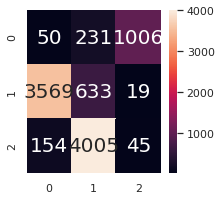

In [39]:
matplotlib.rcParams.update({'font.size': 20})
sns.heatmap(cm,annot=True,fmt='g')
plt.savefig("{}{}_cm.png".format(outpath,dataname),bbox_inches="tight")

In [40]:
for i in range(3):
  
  print(cm[i,i]/cm[i].sum(), cm[i].sum())

0.03885003885003885 1287
0.1499644633972992 4221
0.010704091341579448 4204


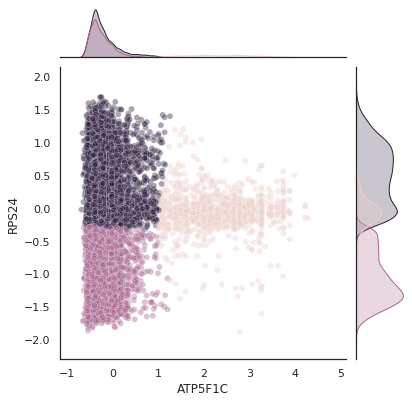

In [41]:
# comp_dict = {"Endothelial" : u'#1f77b4', "Epithelial" : u'#ff7f0e', "Immune" : u'#d62728',"Stromal" :  u'#2ca02c'}
# comp_dict = {"Endothelial" : u'#1f77b4', "Epithelial" : u'#ff7f0e', "Immune" : u'#2ca02c',"Stromal" :  u'#d62728'}
g = sns.jointplot(data=test_df[test_df["cluster"] != 4],x="ATP5F1C",y="RPS24",hue="cluster",alpha = 0.4,legend=False)
# g._legend.remove()
# plt.legend()
plt.savefig("{}{}_kmeans.png".format(outpath,dataname),bbox_inches="tight")
plt.show()

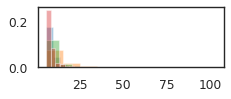

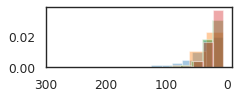

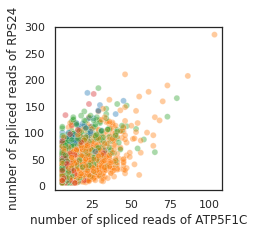

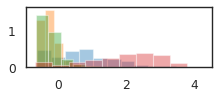

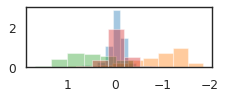

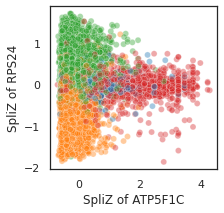

In [42]:
comp_dict = {"Endothelial" : u'#1f77b4', "Epithelial" : u'#ff7f0e', "Immune" : u'#2ca02c',"Stromal" :  u'#d62728'}
sns.set(rc={'figure.figsize':(3,3)})
sns.set_style("white")
df.reset_index(drop=True,inplace=True)
group = "compartment"
cell_map = {x : y for x, y in zip(df["cell"].unique(),range(df["cell"].nunique()))}
df["row"] = df["cell"].map(cell_map)
gene_map = {x : y for x, y in zip(df["geneR1A_uniq"].unique(),range(df["geneR1A_uniq"].nunique()))}

df["column"] = df["geneR1A_uniq"].map(gene_map)
mat = sparse.coo_matrix((df[z_col], (df["row"], df["column"])))
axis_dict = {"num_splicedreads" : "number of spliced reads of", "scZ" : "SpliZ of"}
# comp_dict = {"Immune" : u'#1f77b4', "Endothelial" : u'#ff7f0e', "Epithelial" :u'#d62728', "Stromal" :  u'#2ca02c',
#              "immune" : u'#1f77b4', "endothelial" : u'#ff7f0e', "epithelial" :u'#d62728', "stromal" :  u'#2ca02c',
#             "epithelial or stromal" : "purple","hematopoietic" : "yellow","neural" : "gray", "germ" : "gray"}

# comp_dict = {"Endothelial" : u'#1f77b4', "Epithelial" : u'#ff7f0e', "Immune" : u'#d62728',"Stromal" :  u'#2ca02c'}
for col in ["num_splicedreads", "scZ"]:
  mat = sparse.coo_matrix((df[col], (df["row"], df["column"])))
  mat = mat.todense()
  plot_df = pd.concat([pd.DataFrame(mat,columns=comp_genes), df[['compartment',"tissue"]]], axis = 1).dropna()
  for gene in ["ATP5F1C","RPS24"]:
    plt.figure(figsize=(3, 1), dpi=80)
    for comp, comp_df in plot_df.groupby("compartment"):
      plt.hist(comp_df[gene],alpha = 0.4, color = comp_dict[comp],density=True)
    if gene == "RPS24":
      plt.gca().invert_xaxis()
    plt.savefig("{}{}_{}_all_tissues_{}_{}_hist.png".format(outpath,dataname, "_".join(comp_genes),col,gene),bbox_inches="tight")
    plt.show()
  #   g = sns.jointplot(data=plot_df,x="ATP5F1C",y="RPS24",hue="compartment",alpha = 0.4,palette = comp_dict,legend=False)
  g = sns.scatterplot(data=plot_df,x="ATP5F1C",y="RPS24",hue="compartment",alpha = 0.4,palette = comp_dict,legend=False)



#   for g, gdf in plot_df.groupby(group):
#     plt.plot(gdf[comp_genes[0]], gdf[comp_genes[1]],marker="o",linestyle="",alpha = .5,mfc="none",color=comp_dict[g],label=g)
  plt.xlabel("{} {}".format(axis_dict[col],comp_genes[0]))
  plt.ylabel("{} {}".format(axis_dict[col],comp_genes[1]))

#   g.ax_joint.set_yscale("log")
#   plt.title(col)
#   plt.legend(bbox_to_anchor=(1,1))
  # plt.xscale("log")
  # plt.yscale("log")
  plt.savefig("{}{}_{}_all_tissues_{}.png".format(outpath,dataname, "_".join(comp_genes),col),bbox_inches="tight")
  plt.show()
  

Bladder


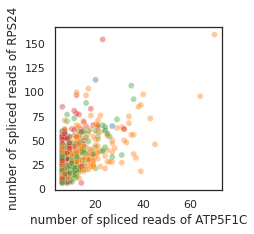

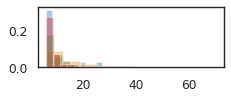

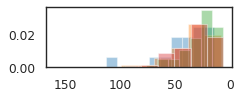

Blood


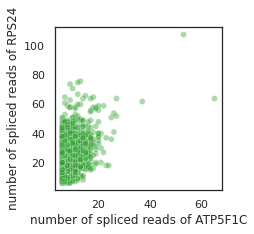

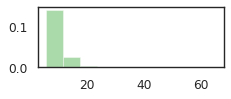

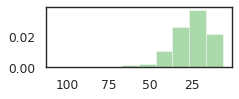

Bone_Marrow


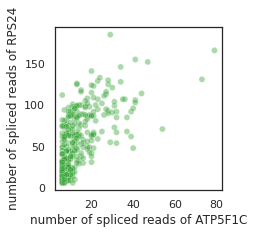

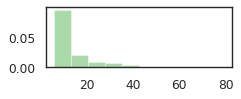

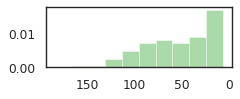

Large_Intestine


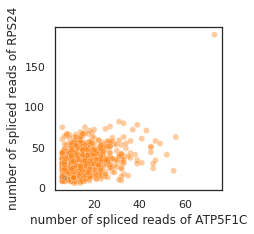

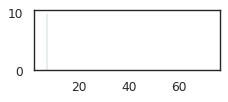

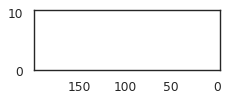

Lung


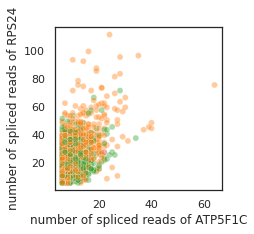

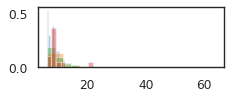

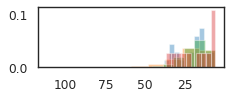

Lymph_Node


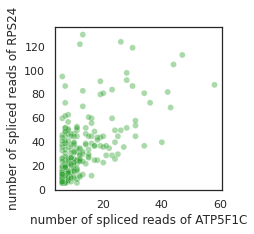

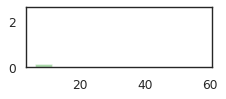

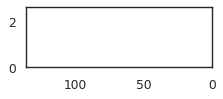

Muscle


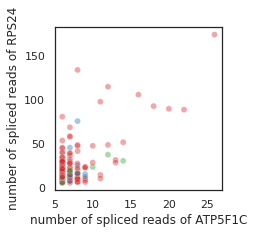

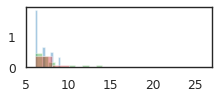

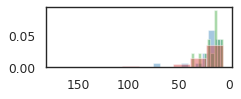

Small_Intestine


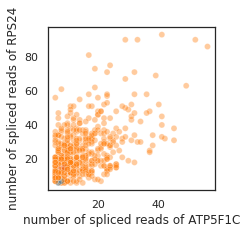

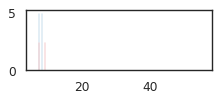

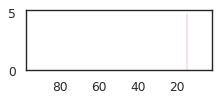

Spleen


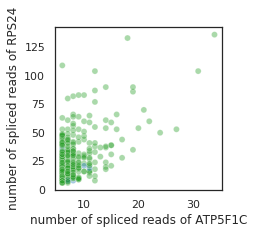

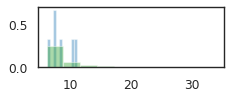

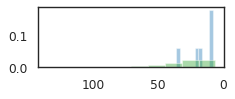

Thymus


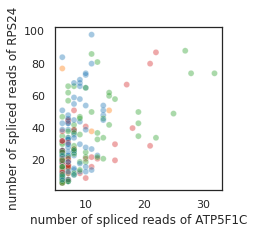

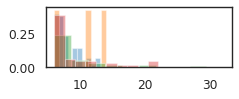

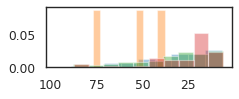

Trachea


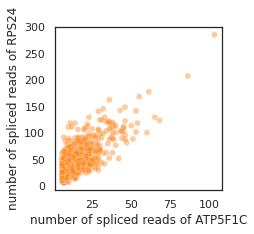

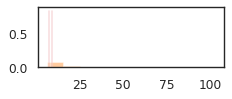

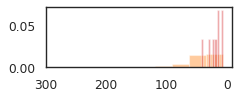

Vasculature


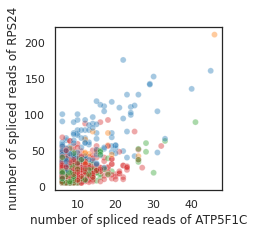

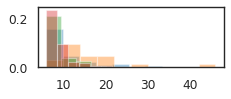

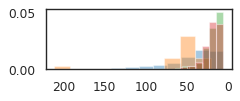

Bladder


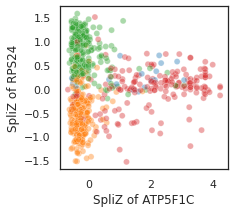

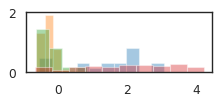

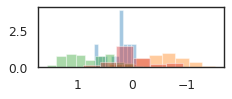

Blood


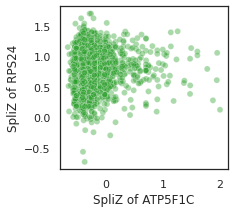

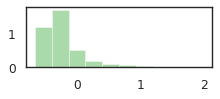

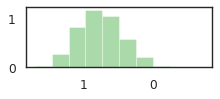

Bone_Marrow


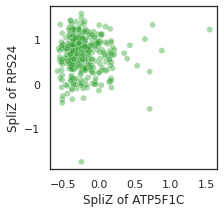

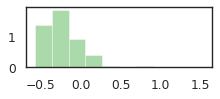

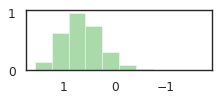

Large_Intestine


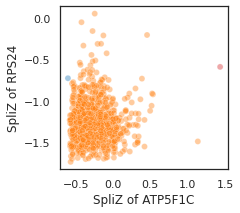

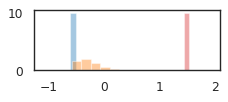

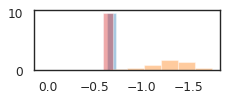

Lung


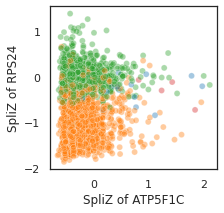

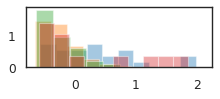

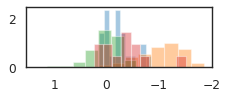

Lymph_Node


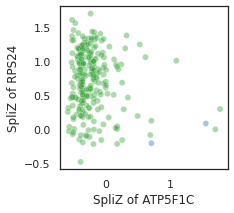

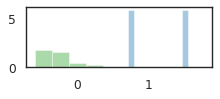

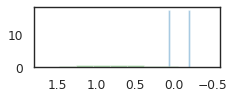

Muscle


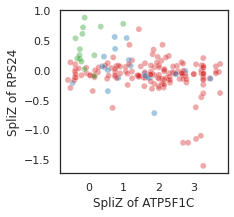

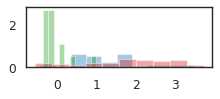

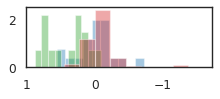

Small_Intestine


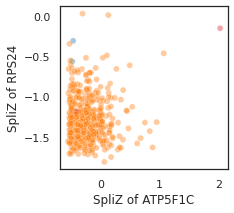

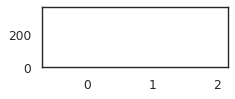

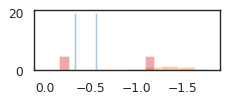

Spleen


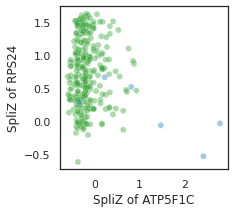

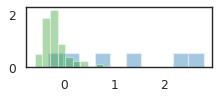

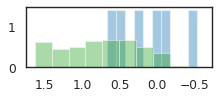

Thymus


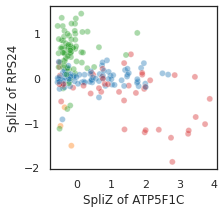

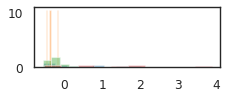

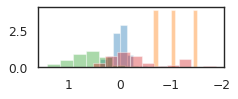

Trachea


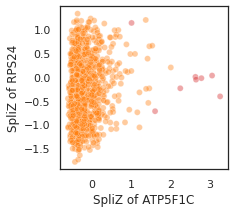

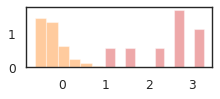

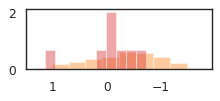

Vasculature


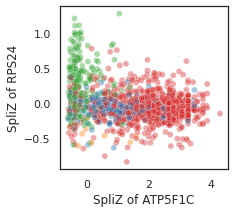

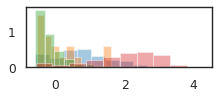

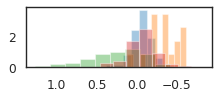

In [43]:
df.reset_index(drop=True,inplace=True)
group = "compartment"
cell_map = {x : y for x, y in zip(df["cell"].unique(),range(df["cell"].nunique()))}
df["row"] = df["cell"].map(cell_map)
gene_map = {x : y for x, y in zip(df["geneR1A_uniq"].unique(),range(df["geneR1A_uniq"].nunique()))}

df["column"] = df["geneR1A_uniq"].map(gene_map)
mat = sparse.coo_matrix((df[z_col], (df["row"], df["column"])))
# comp_dict = {"Immune" : u'#1f77b4', "Endothelial" : u'#ff7f0e', "Epithelial" :u'#d62728', "Stromal" :  u'#2ca02c'}

for col in ["num_splicedreads", "scZ"]:
  mat = sparse.coo_matrix((df[col], (df["row"], df["column"])))
  mat = mat.todense()
  plot_df = pd.concat([pd.DataFrame(mat,columns=comp_genes), df[['compartment',"tissue"]]], axis = 1).dropna()

  
  for tiss, tiss_df in plot_df.groupby("tissue"):
    print(tiss)
#     g = sns.jointplot(data=tiss_df,x="ATP5F1C",y="RPS24",hue="compartment",alpha = 0.4,palette = comp_dict,legend=False)
    g = sns.scatterplot(data=tiss_df,x="ATP5F1C",y="RPS24",hue="compartment",alpha = 0.4,palette = comp_dict,legend=False)

#     for g, gdf in tiss_df.groupby(group):
#       plt.plot(gdf[comp_genes[0]], gdf[comp_genes[1]],marker="o",linestyle="",alpha = 1,color=comp_dict[g],label=g,mfc="none")
    plt.xlabel("{} {}".format(axis_dict[col],comp_genes[0]))
    plt.ylabel("{} {}".format(axis_dict[col],comp_genes[1]))
#     plt.title("{}".format(tiss))
#     plt.legend(bbox_to_anchor=(1,1))
    # plt.xscale("log")
    # plt.yscale("log")
    plt.savefig("{}{}_{}_{}_{}.png".format(outpath,dataname, "_".join(comp_genes),tiss,col),bbox_inches="tight")

    plt.show()
    for gene in ["ATP5F1C","RPS24"]:
      plt.figure(figsize=(3, 1), dpi=80)
      for comp, comp_df in tiss_df.groupby("compartment"):
        plt.hist(comp_df[gene],alpha = 0.4, color = comp_dict[comp],density=True)
      if gene == "RPS24":
        plt.gca().invert_xaxis()
      plt.savefig("{}{}_{}_{}_{}_{}_hist.png".format(outpath,dataname, "_".join(comp_genes),tiss,col,gene),bbox_inches="tight")
      plt.show()